In [1]:
from tqdm import tqdm
import numpy as np
import  matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('classic')
np.random.seed(1) 

In [2]:
n = 40 # Amount of data points
d = 100 # dimension of the data
test = 1000
alpha = 0.01

# Sample x iid from normal dist
x = np.random.normal(0,1, (n,d))
xtest = np.random.normal(0,1, (test,d))

# Generate B^* st 0 norm is 5 (there are 5 non zero elements)
Breal = np.zeros(d)
Breal[ :5] = np.random.normal(1,1, 5)

# Make y from x and B^*
y = np.inner(Breal,x)
ytest = np.inner(Breal,xtest)

Breal

array([1.10192333, 1.30744558, 2.15889379, 1.06345808, 2.54271005,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [3]:
# Initialise training B with scale alpha
wplus = np.ones(d)*alpha
wmin = np.ones(d)*alpha

In [4]:
def Backward(x, y, B, gamma, wplus, wmin):
    '''Backward step for SGD with Batchsize one on Diagonal Linear Networks with quadratic parameterization.'''
    
    i = np.random.randint(0,n) # 1
    gradL = np.inner(wplus*wplus - wmin*wmin - B,x[i]) # 1
        
    wplus = wplus - gamma * gradL * x[i]*wplus
    wmin = wmin + gamma * gradL * x[i]* wmin
    
    return(wplus, wmin)

In [5]:
def NTK(x, wplus, wmin):
    
    NTKplus = wplus * x #(200,100)
    NTKmin = -wmin * x
 
    NTK = np.transpose(np.concatenate((np.transpose(NTKplus), np.transpose(NTKmin))))

    u, s, v = np.linalg.svd(NTK)
    
    NTKrank = np.sum(s > 0.1)
    
    return(NTKrank, s)

In [6]:
def Forward(x, y, wplus, wmin,n):
    '''Forward step for Diagonal Linear Networks with quadratic parameterization.'''
    
    Loss = np.linalg.norm(np.inner(wplus*wplus - wmin*wmin, x) - y)**2/(4*n)
    
    return(Loss)

In [7]:
# Setup training
def Training(wplus, wmin, x, y, Breal, xtest, ytest, n, test, seed, Time, gamma, Timedecay, gammadecay):
    
    np.random.seed(seed)
    
    steps = int(Time/gamma)
    stepsdecay = int(Timedecay/gammadecay)
    
    Loss = []
    TestLoss = []

    NTKrankall = []
    eigenvalues = []
    
    NTKrank ,s= NTK(xtest[:int(2*len(wplus))], wplus, wmin)
    
    eigenvalues.append(s)
    NTKrankall.append(NTKrank)
    
    for j in range(steps):
        
        L = Forward(x, y, wplus, wmin,n)
        Ltest = Forward(xtest, ytest, wplus, wmin,test)
        
        Loss.append(L)
        TestLoss.append(Ltest)
        
        #print(NTKrank)
        if L > 10000:
            
            NTKrank,s = NTK(xtest[:int(2*len(wplus))], wplus, wmin)
            
            eigenvalues.append(s)  
            NTKrankall.append(NTKrank)
            
            return(wplus, wmin, Loss, TestLoss, NTKrankall,eigenvalues)
        
        wplus, wmin = Backward(x, y, Breal, gamma, wplus, wmin)
    
    for j in range(stepsdecay):
        
        L = Forward(x, y, wplus, wmin,n)
        Ltest = Forward(xtest, ytest, wplus, wmin,test)
        
        Loss.append(L)
        TestLoss.append(Ltest)
        
        if L > 10000:
            
            NTKrank,s = NTK(xtest[:int(2*len(wplus))], wplus, wmin)
         
            eigenvalues.append(s)  
            NTKrankall.append(NTKrank)
            
            return(wplus, wmin, Loss, TestLoss, NTKrankall, eigenvalues)
        
        wplus, wmin = Backward(x, y, Breal, gammadecay, wplus, wmin)
        
    NTKrank,s = NTK(xtest[:int(2*len(wplus))], wplus, wmin)
   
    eigenvalues.append(s)  
    NTKrankall.append(NTKrank)
    
    return(wplus, wmin, Loss, TestLoss, NTKrankall, eigenvalues)

In [8]:
itterations = 1000
Time = 100
gamma = [0.04, 0.06, 0.08, 0.1, 0.12, 0.13]
Timedecay = 10
gammadecay = 0.0008 # divide the learning rate by this factor when decaying starts
seed = range(1,itterations+1)

Total_Losses = []
Total_Test_Losses = []

Total_NTKrank = []
Total_eigenvalues = []

for j in tqdm(range(itterations)): 
    
    Losses = []
    TestLosses = []
    
    NTKranks = []
    eigenvalues = []
    for i in range(len(gamma)):

        a_s_res, w_s_res, Loss, TestLoss, NTKrank, eigen = Training(wplus, wmin, x, y, Breal, xtest, ytest, n, test, seed[j], Time, gamma[i], Timedecay, gammadecay)
        
        Losses.append(Loss)
        TestLosses.append(TestLoss)
        eigenvalues.append(eigen)
        NTKranks.append(NTKrank)
    
    Total_Losses.append(Losses)
    Total_Test_Losses.append(TestLosses)
    
    Total_NTKrank.append(NTKranks)
    Total_eigenvalues.append(eigenvalues)

100%|██████████| 1000/1000 [59:14<00:00,  3.55s/it] 


In [9]:
RankLoss = [[],[],[],[],[],[],[]]
for j in range(len(gamma)):
    for i in range(itterations):
        if Total_Losses[i][j][-1]<0.01:
            #plt.plot(Total_NTKrank[i][j])
            RankLoss[j].append([Total_Test_Losses[i][j][-1], Total_NTKrank[i][j][1]])

In [10]:
itterations = 1000
Time = 100
gamma = [0.04, 0.06, 0.08, 0.1, 0.12, 0.13]
Timedecay = 10
gammadecay = 0.0008 # divide the learning rate by this factor when decaying starts

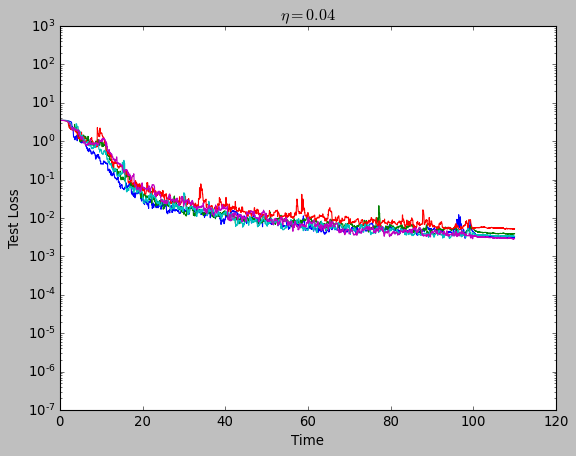

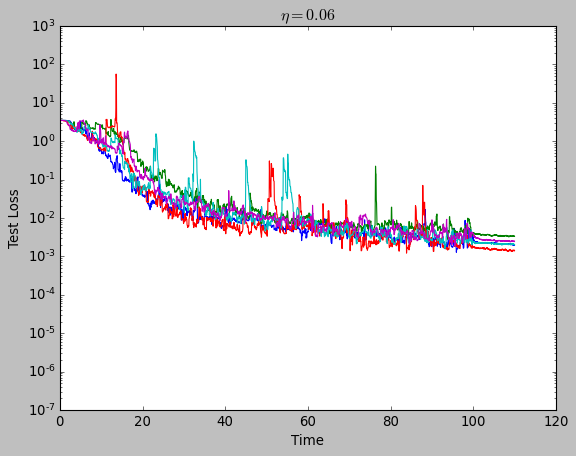

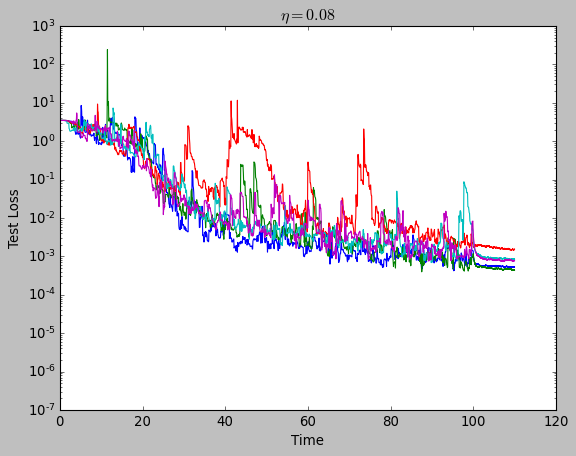

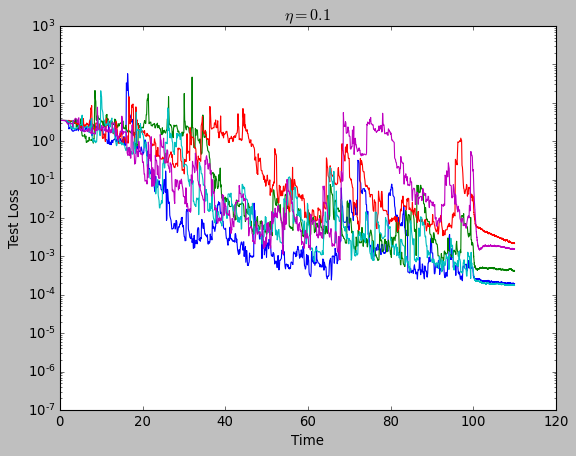

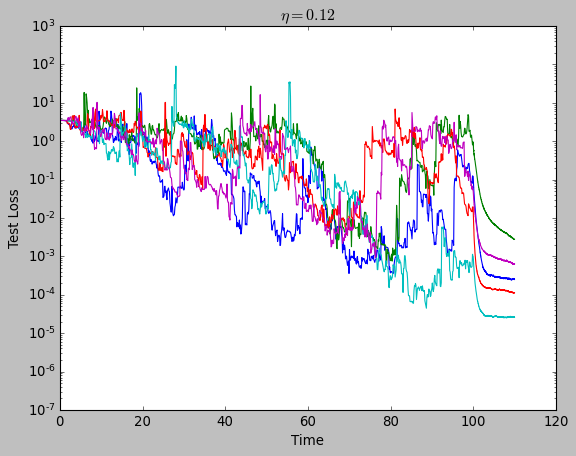

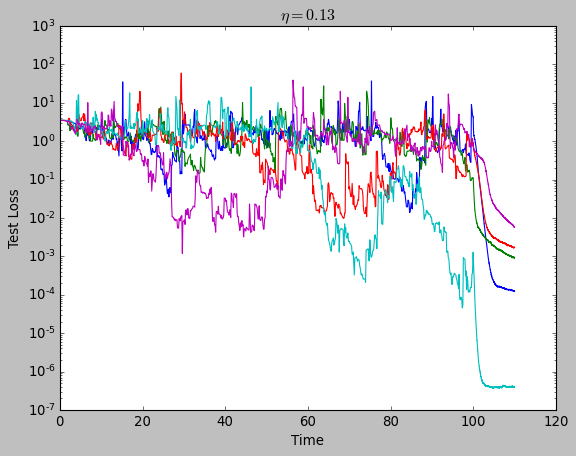

In [11]:
for j in range(len(gamma)):
    count = 0
    for i in range(itterations):
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            steps = np.arange(0,int(Time),gamma[j])
            stepsdecay = np.arange(Time,Time +Timedecay,gammadecay)
            
            Totalsteps = np.append(steps,stepsdecay)
            
            if len(Totalsteps) > len(Total_Test_Losses[i][j]):
                Totalsteps = Totalsteps[:-1]
            plt.plot(Totalsteps,Total_Test_Losses[i][j])
            if count > 4:
                break
                
    plt.ylim(10e-8,10e2)
    plt.yscale('log')
    plt.title(f'$\eta = {gamma[j]}$')
    plt.xlabel('Time')
    plt.ylabel('Test Loss')
    plt.savefig(f'TestlossDLN{gamma[j]}.pdf')
    plt.show()
    plt.close()

C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, nan, nan, nan, nan, 5.495421018385583e-10, 0.0006684792739107008, 0.00010686834521153546, 0.0008322327138101664, 0.0011895630840705188, 0.0014843925178102927, 0.0015932199796117245, 0.00047171429905460923, 0.002042221338192854, 0.0018695219321739562, 0.000612590998359893, 0.0013758775397416459, 0.0008874592467696688, 0.0006041957413155071, 0.0020126745177492925, 0.0016094674660595207, 0.001324850007943564, 0.0014438227494584155, 0.000580399803134761, 0.000663906763978163, 0.0016127158664692514, 0.0006900047393089535, 0.0005244244867842072, 0.00071869340996368, 0.0010210994824809065, 0.0007308016628473867, 0.0017925079264103638, 0.0014082283139719152, 0.0009896106158645101, 0.0011054963899697335, 0.0012056099195324212, 0.001477249241326641, 0.0010798598347498054, 0.0011562545619625763, 0.0008289556113523352, 0.0017333882941470938, 0.00106533621385276, 0.0012578413701558463, 0.0009277278819447665, 0.000998904472099764, 0.0015315483088663131, 0.0014457801103496249, 0.002734367272796

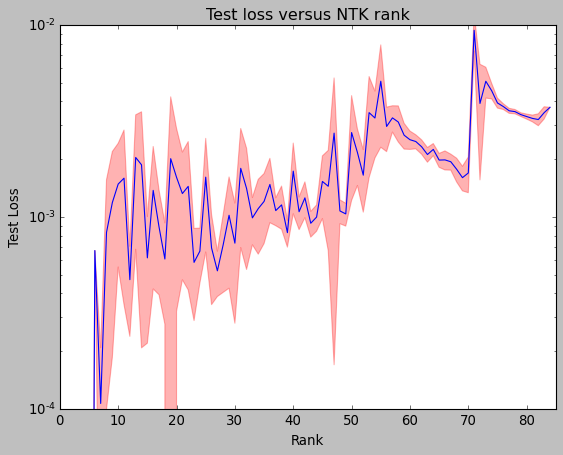

In [12]:
Mean = []
Up = []
Down = []
for j in range(100):
    group = []
    for i in range(6):
        res = np.transpose(np.array(RankLoss[i]))
      
        for k in res[:,res[1] == j][0]:
            group.append(k)
    
    Mean.append(np.mean(group))
    Up.append(np.mean(group)+1.96*np.std(group)/np.sqrt(len(group)))
    Down.append(np.mean(group)-1.96*np.std(group)/np.sqrt(len(group)))
       
plt.plot(range(100),Mean)
plt.fill_between(range(100), Down, Up, color='red', alpha=.3)

print(Mean)
plt.yscale('log')
plt.xlim(0,85)
plt.ylim(1e-4,1e-2)
plt.title(f'Test loss versus NTK rank')
plt.xlabel('Rank')
plt.ylabel('Test Loss')
plt.savefig(f'TestLossNTKRankDLN.pdf')
plt.show()
plt.close()

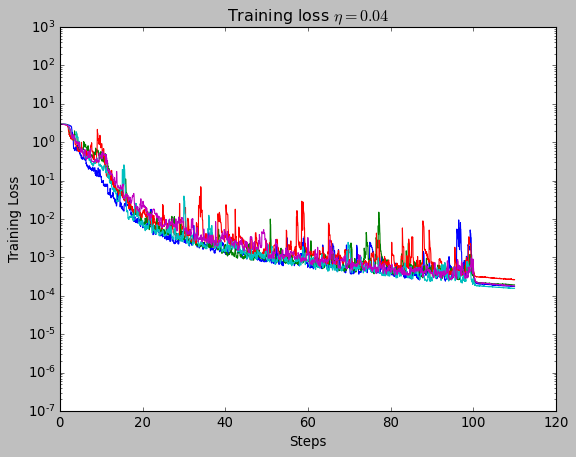

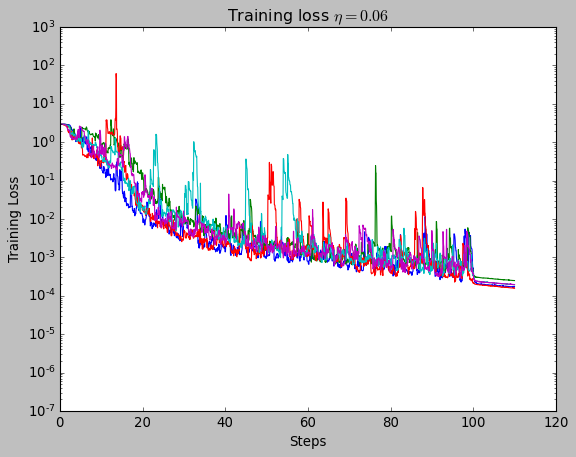

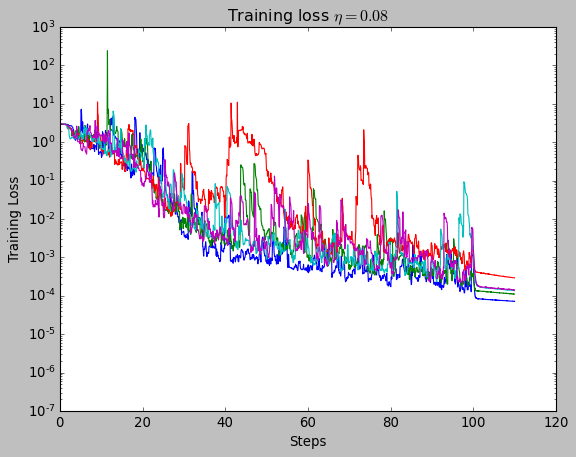

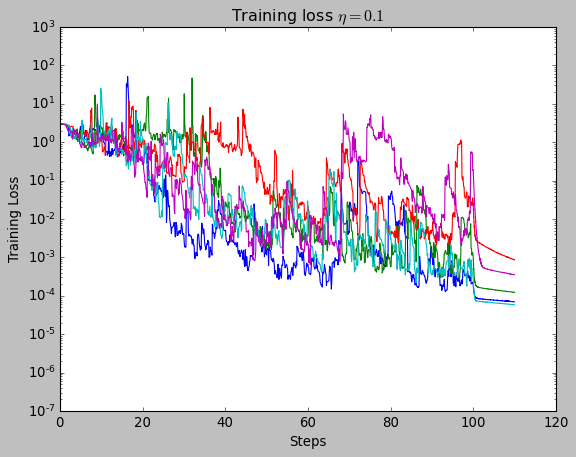

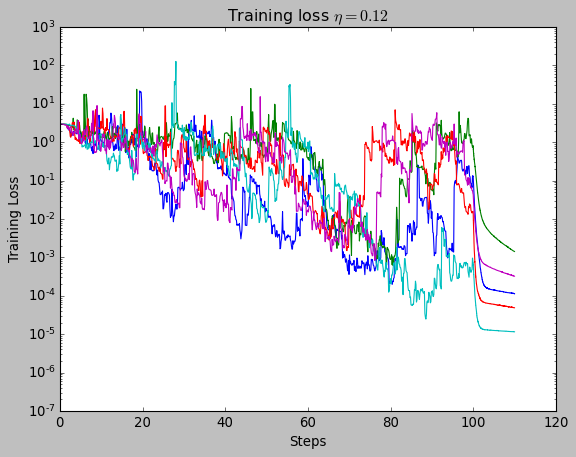

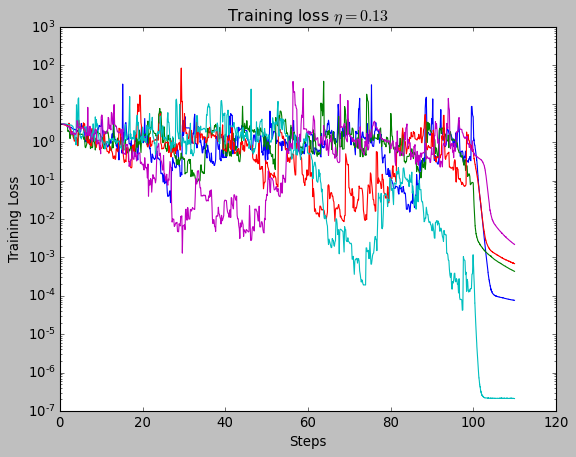

In [13]:
for j in range(len(gamma)):
    count = 0
    for i in range(itterations):
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            steps = np.arange(0,int(Time),gamma[j])
            stepsdecay = np.arange(Time,Time +Timedecay,gammadecay)
            
            Totalsteps = np.append(steps,stepsdecay)
           
            if len(Totalsteps) > len(Total_Losses[i][j]):
                Totalsteps = Totalsteps[:-1]
            plt.plot(Totalsteps,Total_Losses[i][j])
            if count > 4:
                break
    plt.ylim(10e-8,10e2)
    plt.yscale('log')
    plt.title(f'Training loss $\eta = {gamma[j]}$')
    plt.xlabel('Steps')
    plt.ylabel('Training Loss')
   
    plt.savefig(f'TrainingLossDLN{gamma[j]}.pdf')
    
    plt.show()
    plt.close()

0.04


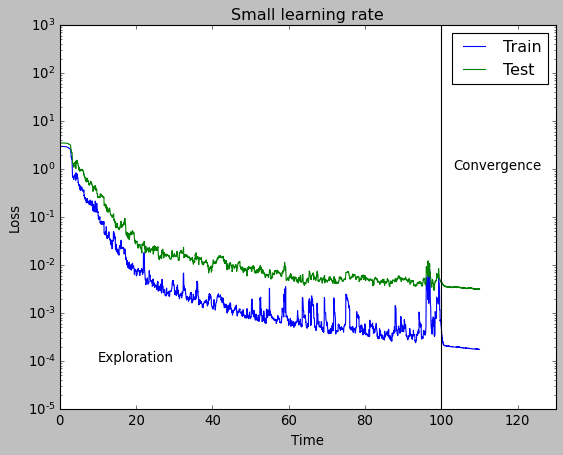

In [14]:
j = 0
count = 0
print(gamma[j])
for i in range(itterations):
    if Total_Losses[i][j][-1]<0.01:
        count += 1
        steps = np.arange(0,int(Time),gamma[j])
        stepsdecay = np.arange(Time,Time +Timedecay,gammadecay)

        Totalsteps = np.append(steps,stepsdecay)

        if len(Totalsteps) > len(Total_Losses[i][j]):
            Totalsteps = Totalsteps[:-1]
        plt.plot(Totalsteps,Total_Losses[i][j], label = 'Train')
        plt.plot(Totalsteps,Total_Test_Losses[i][j], label = 'Test')
        if count > 0:
            break
plt.xlim(0,130)
plt.ylim(10e-6,10e2)
plt.yscale('log')
plt.title(f'Small learning rate')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()
   
plt.axvline(100, color='black')
plt.text(10,10e-5, 'Exploration')
plt.text(103, 10e-1, 'Convergence')

plt.savefig(f'SmallLearninRateIntro.pdf')
    
plt.show()
plt.close()

0.13


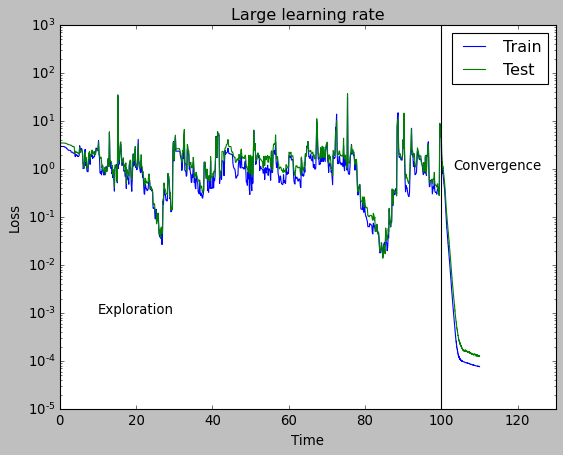

In [15]:
j = 5
count = 0
print(gamma[j])
for i in range(itterations):
    if Total_Losses[i][j][-1]<0.01:
        count += 1
        steps = np.arange(0,int(Time),gamma[j])
        stepsdecay = np.arange(Time,Time +Timedecay,gammadecay)

        Totalsteps = np.append(steps,stepsdecay)

        if len(Totalsteps) > len(Total_Losses[i][j]):
            Totalsteps = Totalsteps[:-1]
        plt.plot(Totalsteps,Total_Losses[i][j], label = 'Train')
        plt.plot(Totalsteps,Total_Test_Losses[i][j], label = 'Test')
        if count > 0:
            break
plt.ylim(10e-6,10e2)
plt.xlim(0,130)
plt.yscale('log')
plt.title(f'Large learning rate')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()

plt.axvline(100, color='black')
plt.text(10,10e-4, 'Exploration')
plt.text(103, 10e-1, 'Convergence')

plt.savefig(f'LargeLearningRateIntro.pdf')
    
plt.show()
plt.close()

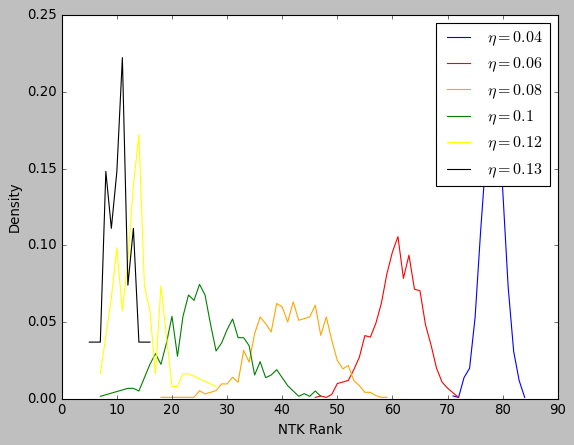

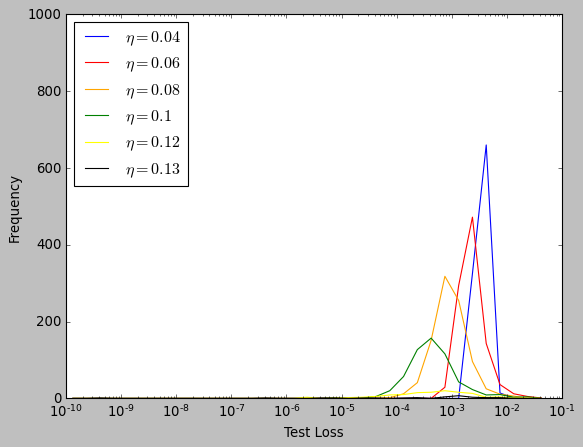

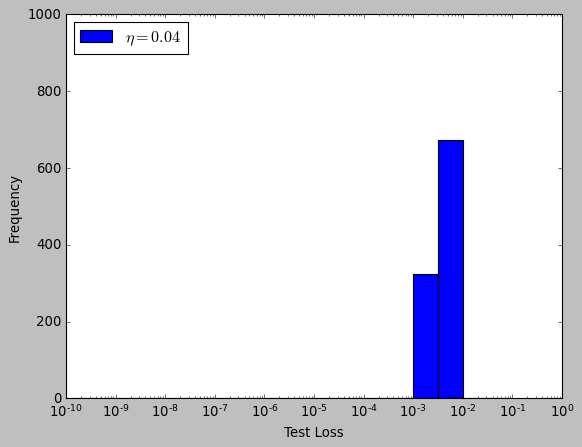

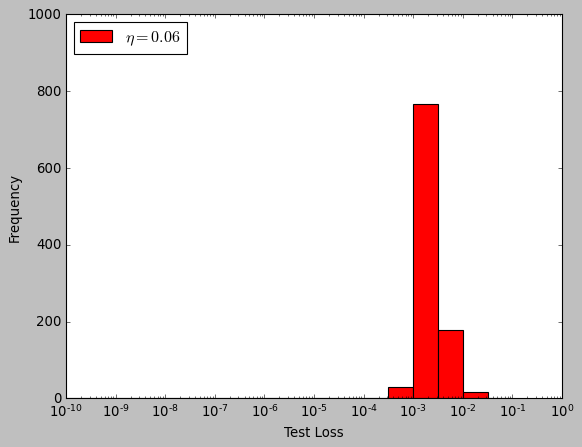

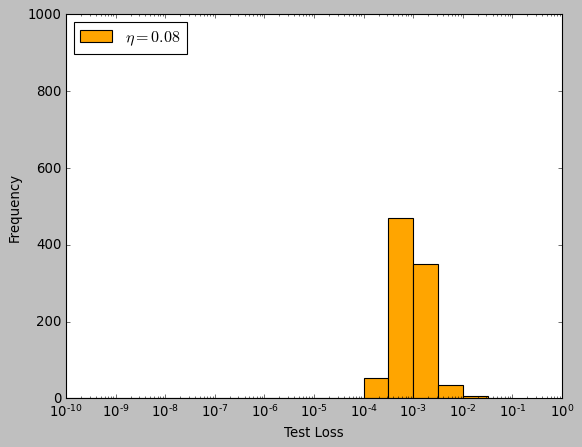

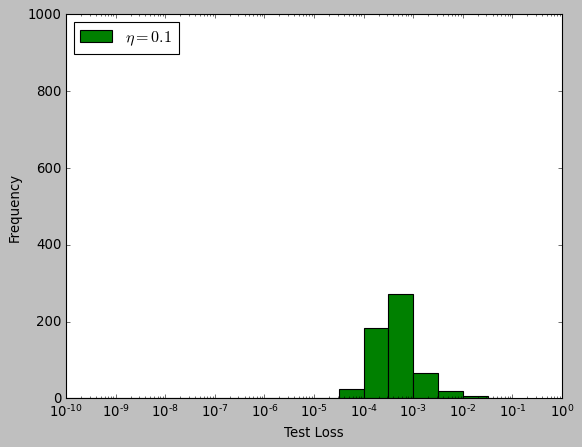

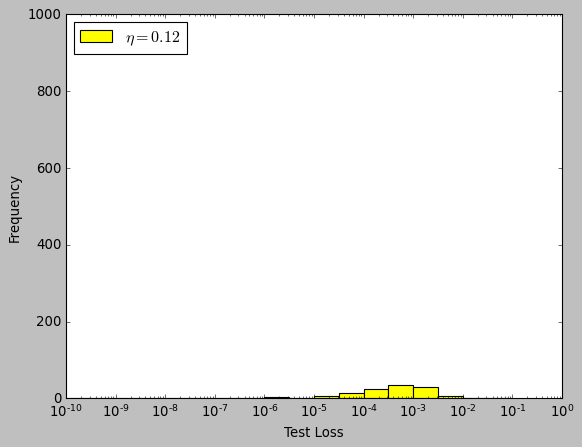

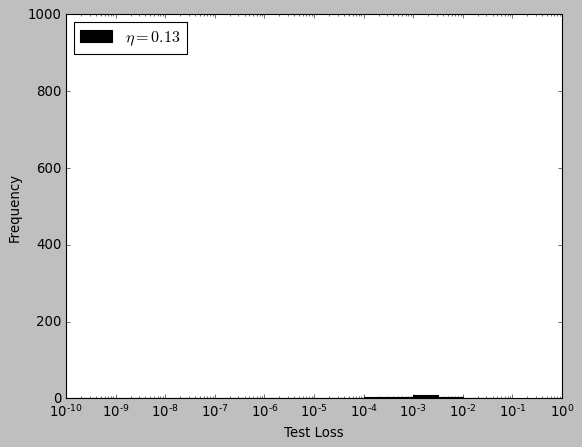

In [16]:
colors = ['blue', 'red', 'orange', 'green','yellow', 'black']
gamma =  [0.04, 0.06, 0.08, 0.1, 0.12, 0.13]
for i in range(len(gamma)):
    res = np.transpose(np.array(RankLoss[i]))        
    res2 = np.unique(res[1], return_counts=True)
    plt.plot(res2[0],res2[1]/len(res[1]),label = f'$\eta = {gamma[i]}$', c = colors[i])
plt.xlabel('NTK Rank')
plt.ylabel('Density')
plt.legend()
plt.savefig('DensityNTKDLN.pdf')
plt.show()
plt.close()
for i in range(len(gamma)):
    res = np.transpose(np.array(RankLoss[i])) 
    b = [10**(-10+ 0.25*i) for i in range(36)]
    hist, binn = np.histogram(res[0], bins = b )
    #print(hist, binn)
    points = [10**(-9.875+0.25*i) for i in range(35)]
    plt.plot(points, hist, label = f'$\eta = {gamma[i]}$', c = colors[i])
    #plt.hist(res[0], color = colors[i], alpha =0.9, bins = [1e-10,10**(-9.5),1e-9,10**(-8.5),1e-8,10**(-7.5),1e-7,10**(-6.5),1e-6,10**(-5.5),1e-5,10**(-4.5),1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),1e-1], label = f'learning rate {gamma[i]}')
plt.legend(loc = 2)
plt.xscale('log')
plt.ylim(0,1000)
plt.xlabel('Test Loss')
plt.ylabel('Frequency')
   # plt.title(f'Test loss distribution with decay at {100*percentage_decay[i]}%')
plt.savefig(f'LossDistdecayDLN.pdf')
plt.show()
plt.close()

for i in range(len(gamma)):
    res = np.transpose(np.array(RankLoss[i]))        
    plt.hist(res[0], color = colors[i], bins = [1e-10,10**(-9.5),1e-9,10**(-8.5),1e-8,10**(-7.5),1e-7,10**(-6.5),1e-6,10**(-5.5),1e-5,10**(-4.5),1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),1e-1], label = f'$\eta = {gamma[i]}$')
    plt.legend(loc =2)
    plt.xscale('log')
    plt.ylim(0,1000)
    plt.xlabel('Test Loss')
    plt.ylabel('Frequency')
   # plt.title(f'Test loss distribution with decay at {100*percentage_decay[i]}%')
    plt.savefig(f'LossDistdecayDLN{gamma[i]}.pdf')
    plt.show()
    plt.close()

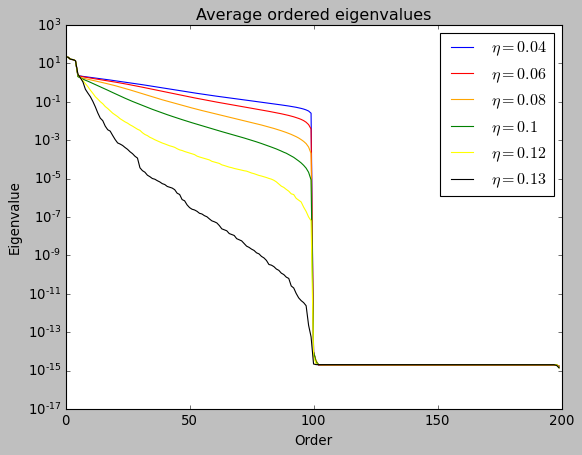

In [17]:
for j in range(len(gamma)):
    count = 0
    Rankedavg = np.zeros(200)
    for i in range(1000):
        
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            Rankedavg += np.array(Total_eigenvalues[i][j][1])
            
    plt.plot(Rankedavg/count,label = f'$\eta = {gamma[j]}$', c = colors[j]) 
    #print(Rankedavg/count)
plt.yscale('log')
plt.ylim(10e-18,10e2)
plt.xlim(0,200)

plt.legend()
plt.xlabel('Order')
plt.ylabel('Eigenvalue')
plt.title('Average ordered eigenvalues')


plt.savefig('OrderedEigenDLNseperate.pdf')
plt.show()
plt.close()

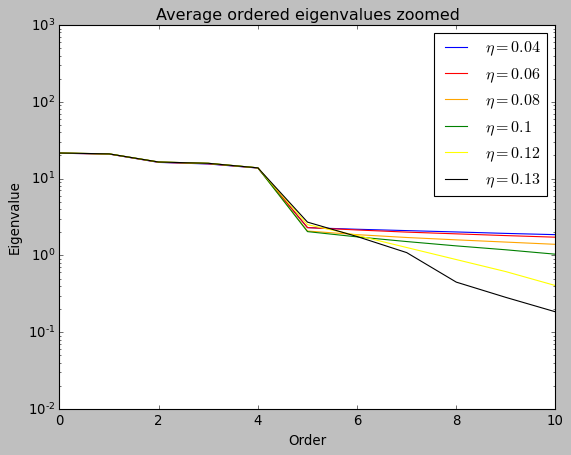

In [18]:
for j in range(len(gamma)):
    count = 0
    Rankedavg = np.zeros(200)
    for i in range(1000):
        
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            Rankedavg += np.array(Total_eigenvalues[i][j][1])
            
    plt.plot(Rankedavg/count,label = f'$\eta = {gamma[j]}$', c = colors[j]) 
    
plt.yscale('log')
plt.ylim(10e-3,10e2)
plt.xlim(0,10)

plt.legend()
plt.xlabel('Order')
plt.ylabel('Eigenvalue')
plt.title('Average ordered eigenvalues zoomed')


plt.savefig('OrderedEigenDLNseperatezoomed.pdf')
plt.show()
plt.close()